# Decision Trees
<span style="font-size: 12px;">By: Marisol Hernandez</span>

In [110]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

## 1. Introduction to Decision Trees
A **decision tree** is a model widely used in Machine Learning to solve both <u>regression</u> and <u>classification</u> problems. It is a graphical model that mimics human decision making, i.e. it is based on a series of questions to reach a conclusion.

The main idea behind decision trees is to divide data into smaller and smaller groups (called nodes) based on different criteria until a final result or decision is reached. These criteria are selected in such a way that the elements of each node are as similar as possible to each other.

### Structure
The structure of a decision tree resembles that of an inverted tree. It starts with a node called **root node** that contains all the data. This node is split into two or more child nodes based on some criterion. These are the **decision nodes**. This process is repeated for each child node, creating what are called **branches**, until a node is reached that is no longer split. These final nodes are called **leaf nodes** and represent the final decision or prediction of the tree.

<p align="center">
  <img src="imgs/decision_trees1.png" alt="Alt text" width="600" height="350">
</p>

An important aspect of decision trees is that they are very interpretable models. You can visualize the entire tree and follow the decisions it makes, which is not possible in many other types of models. However, they can be prone to overfitting, especially if the tree is allowed to grow too large.

## 2. A Simple Example (Classification)
Let’s understand decision trees with the help of an example. Say we want to build a decision tree to determine whether we should play soccer or not.

In [111]:
data_dict = {
    "Weather": ["Sunny", "Cloudy", "Sunny", "Cloudy", "Rainy", "Rainy", "Rainy", "Sunny", "Cloudy", "Rainy"],
    "Humidity": ["High", "High", "Normal", "High", "High", "Normal", "High", "High", "Normal", "High"],
    "Wind": ["Weak", "Weak", "Strong", "Strong", "Strong", "Strong", "Weak", "Strong", "Weak", "Strong"],
    "Play": ["No", "Yes", "Yes", "Yes", "No", "No", "Yes", "No", "Yes", "No"],
}

df = pd.DataFrame(data=data_dict)
df

,Weather,Humidity,Wind,Play
0,Sunny,High,Weak,No
1,Cloudy,High,Weak,Yes
2,Sunny,Normal,Strong,Yes
3,Cloudy,High,Strong,Yes
4,Rainy,High,Strong,No
5,Rainy,Normal,Strong,No
6,Rainy,High,Weak,Yes
7,Sunny,High,Strong,No
8,Cloudy,Normal,Weak,Yes
9,Rainy,High,Strong,No


Decision trees are upside down which means the root is at the top and then this root is split into various several nodes. Decision trees are nothing but a bunch of if-else statements in layman terms. It checks if the condition is true and if it is then it goes to the next node attached to that decision.

In the below diagram the tree will first ask what is the weather? Is it sunny, cloudy, or rainy? If yes then it will go to the next feature which is humidity and wind. It will again check if there is a strong wind or weak, if it’s a weak wind and it’s rainy then the person may go and play.

<p align="center">
  <img src="imgs/decision_trees2.png" alt="Alt text" width="650" height="350">
</p>

Did you notice anything in the above flowchart? We see that if the weather is cloudy then we must go to play. Why didn’t it split more? Why did it stop there?

To answer this question, we need to know about few more concepts like entropy, information gain, and Gini index. But in simple terms, I can say here that the output for the training dataset is always yes for instances where the weather is `"Cloudy"`, since there is no need to split the node further.

In [112]:
# The output is always "Yes" for "Cloudy" data points
df[df["Weather"] == "Cloudy"]

,Weather,Humidity,Wind,Play
1,Cloudy,High,Weak,Yes
3,Cloudy,High,Strong,Yes
8,Cloudy,Normal,Weak,Yes


The goal of machine learning is to decrease uncertainty or disorders from the dataset and for this, we use decision trees.

Now you must be thinking how do I know what should be the root node? What should be the decision node? When should I stop splitting? To decide this, there is a metric called “Entropy” which is the amount of uncertainty in the dataset.

### `scikit-learn`'s Implementation
Lets fit a decision tree to our dataset using `scikit-learn`. 

`scikit-learn`'s implementation requires numerical values, so categorical features need to be preprocessed into a numerical format using either factorization, one-hot-encoding, or another encoding method. To meet this requirement, lets set up a pipeline to transform our categorical features to numeric using label encoding. For this, we create a custom transformer class and set up a pipeline.

Note: The target variable `Play` does not need to be encoded.

In [113]:
# Custom transformer to label encode categorical features
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        self.mapping = {}
    
    def fit(self, X, y=None):
        for column in X.columns:
            le = LabelEncoder()
            le.fit(X[column])
            self.encoders[column] = le
            self.mapping[column] = dict(zip(le.classes_, le.transform(le.classes_)))
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for column, encoder in self.encoders.items():
            X_encoded[column] = encoder.transform(X[column])
        return X_encoded

# Define preprocessing steps
categorical_features = ["Weather", "Humidity", "Wind"]
categorical_transformer = CustomLabelEncoder()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical_preprocessor", categorical_transformer, categorical_features)
    ])

# Define pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier())
])

Now split our features and target variable.

In [114]:
# Split features and target variable
X = df.drop(columns=['Play'])
y = df['Play']

In [115]:
X

,Weather,Humidity,Wind
0,Sunny,High,Weak
1,Cloudy,High,Weak
2,Sunny,Normal,Strong
3,Cloudy,High,Strong
4,Rainy,High,Strong
5,Rainy,Normal,Strong
6,Rainy,High,Weak
7,Sunny,High,Strong
8,Cloudy,Normal,Weak
9,Rainy,High,Strong


In [116]:
y

0     No
1    Yes
2    Yes
3    Yes
4     No
5     No
6    Yes
7     No
8    Yes
9     No
Name: Play, dtype: object

Fit the pipeline.

In [117]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_preprocessor',
                                                  CustomLabelEncoder(),
                                                  ['Weather', 'Humidity',
                                                   'Wind'])])),
                ('classifier', DecisionTreeClassifier())])

We can also see how the `CustomLabelEncoder` transformed our categorical features. We can also see the mapping.

In [118]:
# Transform X using the pipeline
X_transformed = pipeline.named_steps['preprocessor'].transform(X)

# Extract mapping from the custom label encoder
label_mapping = pipeline.named_steps['preprocessor'].named_transformers_['categorical_preprocessor'].mapping
print("Label Encoding Mapping:")
print(label_mapping)

# Combine transformed features with the target variable
df_transformed = pd.DataFrame(X_transformed, columns=categorical_features)
df_transformed['Play'] = y

df_transformed

Label Encoding Mapping:
{'Weather': {'Cloudy': 0, 'Rainy': 1, 'Sunny': 2}, 'Humidity': {'High': 0, 'Normal': 1}, 'Wind': {'Strong': 0, 'Weak': 1}}


,Weather,Humidity,Wind,Play
0,2,0,1,No
1,0,0,1,Yes
2,2,1,0,Yes
3,0,0,0,Yes
4,1,0,0,No
5,1,1,0,No
6,1,0,1,Yes
7,2,0,0,No
8,0,1,1,Yes
9,1,0,0,No


### Decision Tree Visualization
We can also visualize our decision tree.

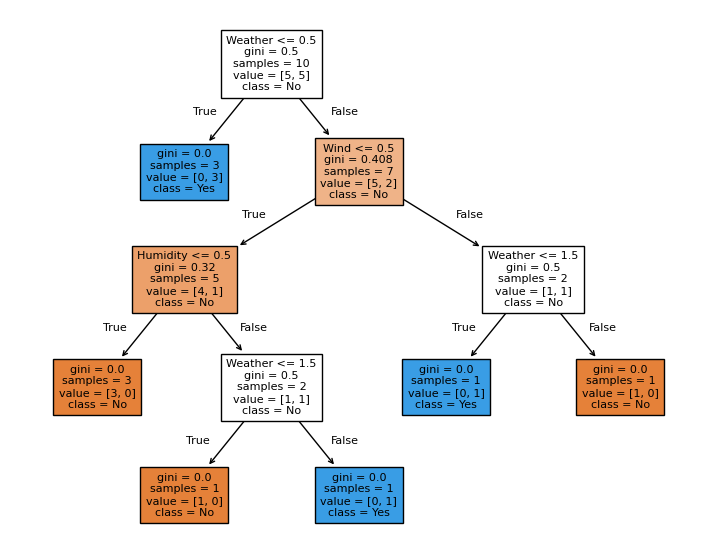

In [119]:
# Visualize the decision tree
plt.figure(figsize=(9, 7))
plot_tree(pipeline['classifier'], feature_names=X.columns, class_names=pipeline['classifier'].classes_, filled=True, fontsize=8)

# Get the axes of the plot
ax = plt.gca()

# Coordinates for True/False labels
coords = [
    (0.28, 0.81, 0.48, 0.81),
    (0.35, 0.62, 0.66, 0.62),
    (0.15, 0.41, 0.35, 0.41),
    (0.65, 0.41, 0.85, 0.41),
    (0.27, 0.2, 0.48, 0.2),
]

# Add True or False labels
for x1, y1, x2, y2 in coords:
    ax.text(x1, y1, 'True', color='black', fontsize=8, ha='center', va='center')
    ax.text(x2, y2, 'False', color='black', fontsize=8, ha='center', va='center')

plt.show()

Each node contains several pieces of information that provide insights into how the tree makes decisions,

<p align="center">
  <img src="imgs/decision_trees4.png" alt="Alt text" width="400" height="150">
</p>

1. **Decision Criteria**: This indicates the feature and threshold used to make the split at the current node. For example, "Humidity <= 0.5" means that the decision tree splits the data based on whether the humidity feature is less than or equal to 0.5.

2. **Gini Impurity or Entropy**: Gini impurity or entropy measures how well a split separates classes. Lower values indicate higher purity, meaning the node predominantly contains instances of a single class.

3. **Samples**: This shows the number of samples that reach the node during the training process. It represents the total number of instances from the dataset that satisfy the conditions to reach this node.

4. **Value**: Value represents the distribution of classes in the node. It indicates the count of instances from each class present in the node. For example, if the value is [5, 10], it means there are 5 instances of one class and 10 instances of another class.

5. **Class**: This indicates the predicted class for the majority of instances in the node. It represents the class label that the decision tree assigns to new instances that reach this node during prediction.

### Making Predictions
Lets define a new data point to make a prediction.

In [120]:
# Define the new data point
new_data_dict = {
    "Weather": ["Sunny"],
    "Humidity": ["High"],
    "Wind": ["Weak"],
}

# Create a DataFrame for the new data point
new_df = pd.DataFrame(data=new_data_dict)
new_df

,Weather,Humidity,Wind
0,Sunny,High,Weak


The pipeline we created will label encode the categorical features, lets see what that looks like.

In [121]:
# Transform the new data point using the preprocessor
new_data_transformed = pipeline.named_steps['preprocessor'].transform(new_df)

# Combine transformed features into a DataFrame
new_data_transformed_df = pd.DataFrame(new_data_transformed, columns=categorical_features)

print("Label Encoding Mapping:")
print(label_mapping)

print("\nTransformed new data point:")
new_data_transformed_df

Label Encoding Mapping:
{'Weather': {'Cloudy': 0, 'Rainy': 1, 'Sunny': 2}, 'Humidity': {'High': 0, 'Normal': 1}, 'Wind': {'Strong': 0, 'Weak': 1}}

Transformed new data point:


,Weather,Humidity,Wind
0,2,0,1


Now lets use the pipeline to make a prediction. The raw data is passed through.

In [122]:
# Use the pipeline to make predictions
prediction = pipeline.predict(new_df)
print("Prediction:", prediction[0])

Prediction: No


Our model's prediction was **No**. We can actually visualize this decision path,

<p align="center">
  <img src="imgs/decision_trees3.png" alt="Alt text" width="650" height="550">
</p>

## 3. A More Complex Example (Classification)
Now we'll explore another example using a dataset that has already been previously treated with a full EDA.

### Step 1. Read and perform EDA on the dataset

In [123]:
# Load the iris dataset
iris = load_iris()

# Create a DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Add the target variable as species names
iris_df['species'] = iris.target
iris_df['species'] = iris_df['species'].apply(lambda x: iris.target_names[x])

# Display the DataFrame
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Understanding the distribution of labels (or categories) in your dataset is a crucial step in data analysis and model building. This step helps you to:
- **Detect Imbalance**: Identify any imbalances in the dataset, where certain classes might be underrepresented. This can affect the performance of your model, especially in classification tasks.

- **Inform Sampling Strategies**: Decide on appropriate sampling strategies, such as oversampling minority classes or undersampling majority classes, to address class imbalance.

- **Evaluate Model Performance**: Ensure that your evaluation metrics take into account the distribution of the classes, particularly if there is a significant class imbalance.

Here is how you can explore the distribution of species in the Iris dataset:

In [124]:
# Get the value counts of each species
iris_df["species"].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

One way to visualize the relationship of variables to the target is by using a new type of graph, `parallel_coordinates`. It's a data visualization technique used to plot multivariate numerical variables:

<Axes: >

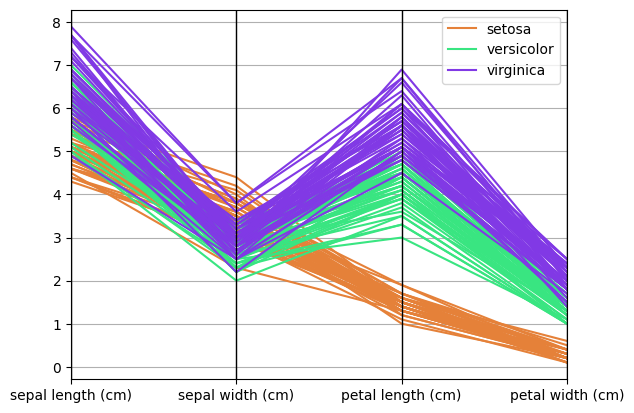

In [125]:
pd.plotting.parallel_coordinates(iris_df, "species", color = ("#E58139", "#39E581", "#8139E5"))

We can appreciate how the values of the predictors are distributed in the different flower classes. This can be a good graph to include in our EDA analysis from now on, as it helps us to identify patterns and correlations between variables.

Before we can do a train/test split we must first separate the features and target.

In [126]:
# Separate the features and target
X = iris_df.drop('species', axis=1)
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [127]:
# Separate the features and target
y = iris_df['species']
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

### Step 2. train/test Split
The *train* set will be used to train the model, while the *test* set will be used to evaluate the effectiveness of the model.

In [157]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (120, 4)
y_train shape: (120,)
X_test shape: (30, 4)
y_test shape: (30,)


In [150]:
# Inspect X_train
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
8,4.4,2.9,1.4,0.2
106,4.9,2.5,4.5,1.7
76,6.8,2.8,4.8,1.4
9,4.9,3.1,1.5,0.1
89,5.5,2.5,4.0,1.3


**Note:** Scaling is not necessary for decision trees. Decision trees are insensitive to the scale of the features because they make decisions based on the feature values' order and thresholds rather than their magnitude. This is one of the advantages of decision trees over other algorithms like logistic regression, support vector machines, or k-nearest neighbors, which can be sensitive to feature scaling.

### Step 3: Model initialization and training

In [130]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Once the model has been trained correctly, we can visualize the tree with the same library. This visualization represents all the steps that the model has followed until the construction of the tree.

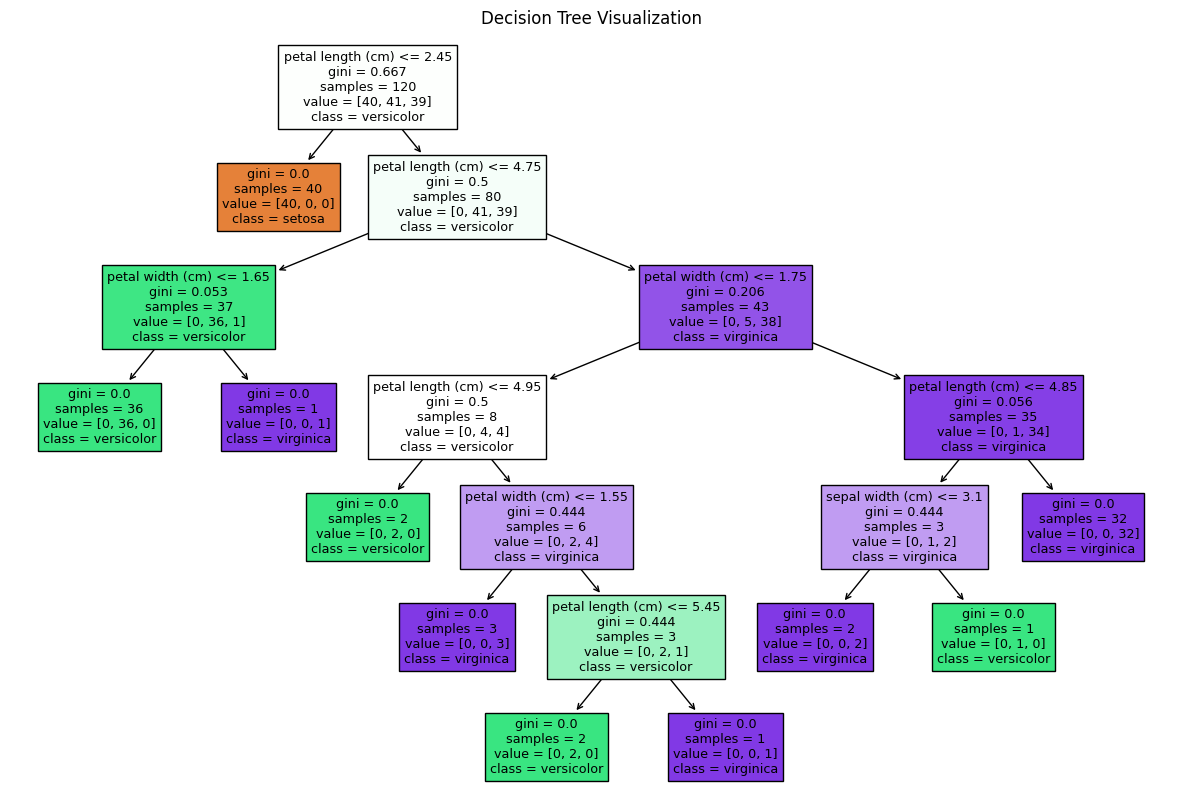

In [131]:
# Visualize the trained decision tree
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

### Step 4: Model Evaluation

Once the model has been trained, it can be used to predict with the test data set.

In [132]:
# Predict the labels for the test set
y_pred = model.predict(X_test)

test_df = X_test.copy()
test_df["species"] = y_test
test_df["Predictions"] = y_pred
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Predictions
73,6.1,2.8,4.7,1.2,versicolor,versicolor
18,5.7,3.8,1.7,0.3,setosa,setosa
118,7.7,2.6,6.9,2.3,virginica,virginica
78,6.0,2.9,4.5,1.5,versicolor,versicolor
76,6.8,2.8,4.8,1.4,versicolor,versicolor


With raw data, it is very difficult to know whether the model is getting it right or not. To do this, we must compare it with reality. There are many metrics to measure the effectiveness of a model in predicting, including accuracy, which is the fraction of predictions that the model makes correctly.

In [133]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=iris.target_names)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Getting an accuracy of 1.0 on both the training and test sets is unusual and can indicate a few different scenarios:

1. **Perfect Model**: The model might be perfectly suited to the data, capturing all patterns without overfitting or underfitting. This is rare, especially with real-world data.

2. **Overfitting**: More commonly, a perfect accuracy score indicates overfitting, where the model has memorized the training data and fails to generalize well to new, unseen data. Overfitting is particularly likely if the model is too complex (e.g., a decision tree with very deep splits).

3. **Simple Dataset**: The dataset might be very simple, with clear, easily separable classes. The Iris dataset is relatively simple, and some models can achieve very high accuracy on it, but achieving a perfect score is still uncommon without overfitting.

To better understand the performance of your model, you can use additional evaluation techniques:

1. **Cross-Validation**: Perform k-fold cross-validation to ensure the model generalizes well across different subsets of the data.

2. **Learning Curves**: Plot learning curves to visualize how training and validation accuracy evolve with different training set sizes.

3. **Regularization**: Apply regularization techniques to prevent overfitting. For decision trees, this can include setting a maximum depth, minimum samples per leaf, or pruning the tree.

Here’s how you can perform cross-validation:

In [134]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.95833333 1.         0.83333333 0.95833333 0.95833333]
Mean cross-validation score: 0.9416666666666668


### Step 5: Model Optimization
Hyperparameter optimization in decision trees involves systematically searching for the best combination of hyperparameters to improve model performance. This process typically uses techniques like grid search or randomized search combined with cross-validation to evaluate different hyperparameter combinations.

Some of a decision tree's hyperparameters include:

- `criterion`: The function to measure the quality of a split.

- `max_depth`: The maximum depth of the tree. This limits how many splits it can have, which is useful to prevent overfitting. If this value is `None`, then nodes are expanded until leaves are pure or until all leaves contain fewer samples than `min_samples_split`

- `min_samples_split`: The minimum number of samples needed to split a node. If a node has less samples than `min_samples_split`, then it will not be split, even if it is not pure. Helps prevent overfitting.

- `min_samples_leaf`: The minimum number of samples that must be in a leaf node. A node will split if doing so creates at least `min_samples_leaf` samples in each of the children. This also helps to prevent overfitting.

- `max_features`: The maximum number of features to consider when looking for the best split. If `max_features` is `None`, then all features will be considered. Reducing this number may make the model simpler and faster to train, but may also cause it to miss some important relationships.

In [135]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [136]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [137]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [1.         1.         0.83333333 1.         0.95833333]
Mean cross-validation score: 0.9583333333333334


### Step 6: Making Predictions

In [138]:
# Generate a new random data point (for demonstration)
new_data_df = pd.DataFrame([[6.0, 3.0, 5.0, 2.0]], columns=iris.feature_names)

# Predict the species of the new data point
predicted_species = best_model.predict(new_data_df)
new_data_df["Prediction"] = predicted_species

new_data_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Prediction
0,6.0,3.0,5.0,2.0,virginica


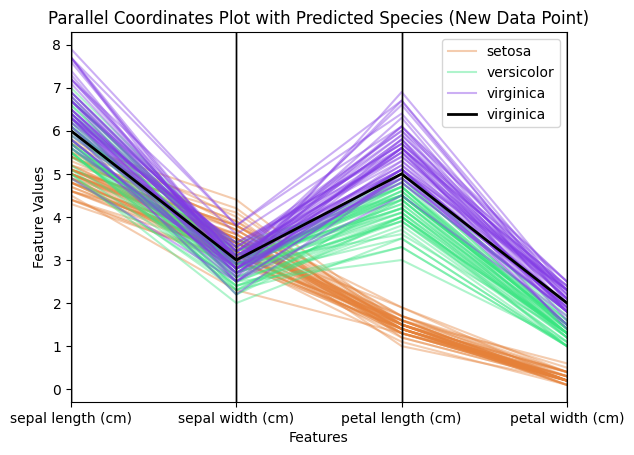

In [139]:
# Plotting using parallel coordinates
pd.plotting.parallel_coordinates(iris_df, "species", color=("#E58139", "#39E581", "#8139E5"), alpha=0.4)
pd.plotting.parallel_coordinates(new_data_df, "Prediction", color="black", linewidth=2)
plt.title('Parallel Coordinates Plot with Predicted Species (New Data Point)')
plt.xlabel('Features')
plt.ylabel('Feature Values')
plt.legend(loc='upper right')
plt.show()

## 4. How decision tree algorithms work?
Decision Tree algorithm works in a series of steps:

1. **Starting at the Root**: The algorithm begins at the top, called the “root node,” representing the entire dataset.

2. **Asking the Best Questions**: It looks for the most important feature or question that splits the data into the most distinct groups. This is like asking a question at a fork in the tree.

3. **Branching Out**: Based on the answer to that question, it divides the data into smaller subsets, creating new branches. Each branch represents a possible route through the tree.

4. **Repeating the Process**: The algorithm continues asking questions and splitting the data at each branch until it reaches the final “leaf nodes,” representing the predicted outcomes or classifications.
